# AML — Task 1
## Predict the age of a brain from MRI features
---

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import zscore
from pandas_profiling import ProfileReport

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.ensemble import IsolationForest

In [3]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

## Import datasets

In [4]:
X_train = pd.read_csv('data/X_train.csv').drop(columns=['id'])
y_train = pd.read_csv('data/y_train.csv').drop(columns=['id'])

In [5]:
X_test = pd.read_csv('data/X_test.csv').drop(columns=['id'])

In [6]:
X_train.describe()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x822,x823,x824,x825,x826,x827,x828,x829,x830,x831
count,1118.000000,1114.000000,1117.000000,1106.000000,1.117000e+03,1128.000000,1105.000000,1127.000000,1.116000e+03,1124.000000,...,1.134000e+03,1125.000000,1098.000000,1121.000000,1120.000000,1109.000000,1115.000000,1.112000e+03,1124.000000,1091.000000
mean,10.026057,832442.859290,20585.524887,1048.958235,1.000291e+06,10.085010,597900.429955,10389.657239,9.998422e+05,785176.225858,...,1.049674e+06,-876.044006,13492.600186,10.554762,10.057767,1066.141107,10.008269,1.050199e+06,99798.480171,104903.905758
std,0.968347,0.028258,0.029051,28.430733,9.740891e+04,0.968026,0.028128,1655.843472,1.022441e+05,0.028799,...,2.839579e+04,164.585576,2519.835006,0.283844,0.982656,226.606986,1.018930,2.814210e+04,9576.128720,2768.405350
min,6.672068,832442.808579,20585.473808,1000.063783,6.800215e+05,6.984052,597900.381003,3644.074892,6.095730e+05,785176.176297,...,1.000105e+06,-1597.766964,2536.030655,10.010366,6.841039,496.007706,6.466963,1.000002e+06,73207.994891,100012.896777
25%,9.381273,832442.835941,20585.501013,1024.969967,9.360882e+05,9.470582,597900.406110,9339.537887,9.322937e+05,785176.201279,...,1.025054e+06,-975.398714,11947.954006,10.321039,9.379001,899.067501,9.325229,1.027575e+06,93416.252400,102596.190683
50%,10.000079,832442.860041,20585.524817,1047.985497,1.000557e+06,10.089601,597900.429787,10295.013382,1.001261e+06,785176.225608,...,1.049296e+06,-875.508235,13352.186179,10.554260,10.114370,1049.027077,10.005684,1.050262e+06,99802.127899,104846.235709
75%,10.664998,832442.882951,20585.550525,1073.180317,1.064617e+06,10.752707,597900.452983,11304.073469,1.068359e+06,785176.250421,...,1.074354e+06,-773.174562,14893.726023,10.792195,10.745370,1215.057985,10.658120,1.073831e+06,106400.748441,107098.669350
max,12.956099,832442.908334,20585.573514,1099.977638,1.331630e+06,12.747734,597900.480810,17347.531573,1.284804e+06,785176.276168,...,1.099771e+06,-281.030205,24815.260375,11.091050,13.530204,2122.032859,13.163113,1.099918e+06,130694.436443,109984.169649


---
## Outlier detection: Isolation Forest

In [7]:
X_train = pd.DataFrame(KNNImputer().fit_transform(X_train))

In [8]:
clf = IsolationForest(random_state=0).fit(X_train)

<AxesSubplot:ylabel='Frequency'>

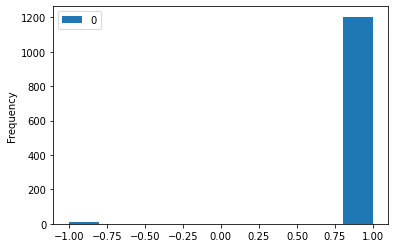

In [9]:
%matplotlib inline
pd.DataFrame(clf.predict(X_train)).plot.hist()

In [10]:
mask = clf.predict(X_train) == 1

In [11]:
X_train = X_train.iloc[mask, :]
y_train = y_train.iloc[mask, :]

---
## Model architectures

**For each `model architecture`:**
1. We define a *model pipeline* without defining hyperparameters.
2. We find *optimal hyperparameters* of this model using `GridSearchCV`.

**To choose the final `model architecture` we use on the *test dataset*:**
1. We take the *model pipeline* that has the best validation score given by `GridSearchCV`

### Pipeline 1: Lasso Regression

1. **Imputation of missing values** using sklearn `KNN Impute`
2. **Data normalization** using sklear `Standard Scale`
3. **Feature selection** using sklearn `Lasso Regression`

***COMMENTS.*** This model passes the baseline but sucks.

In [ ]:
pipe_lasso = Pipeline([
    ('imputer', KNNImputer()), 
    ('scaler', StandardScaler()), 
    ('lasso', Lasso())
])

In [ ]:
grid_params_lasso = {
    'lasso__alpha': np.logspace(-1.5, -0.5, 10),
    'lasso__max_iter': [100000],
}

In [ ]:
simplefilter("ignore", category=ConvergenceWarning)
gs_lasso = GridSearchCV(pipe_lasso, grid_params_lasso, cv=5, verbose=3)
gs_lasso.fit(X_train, y_train)

In [ ]:
gs_lasso.best_score_

### Pipeline 2: Ridge Regression

In [18]:
corr_matrix = X_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

In [13]:
X_train_sel = X_train.drop(X_train[to_drop], axis=1)

In [14]:
X_train[to_drop]

,22,47,52,66,74,80,91,93,101,126,...,791,792,797,800,803,813,819,820,823,824
0,2538.045240,68128.143773,2.075892,5421.067346,-10815.396372,6642.005601,380.221303,-2779.425620,-346204.735158,12579.046512,...,9046.047584,2.586985,11230.077183,2.358928,309702.424398,1857.070822,2.139276,-3163.219791,-855.549602,12176.073427
1,2033.004526,66250.711776,2.234168,5820.082835,-9161.669316,8159.036008,221.861890,-2273.018366,-388288.863048,12735.043244,...,10628.015226,1.796449,10487.069231,1.886463,557053.464687,1818.087105,1.746126,-2661.694233,-787.397942,10493.095660
2,2138.054129,70022.030253,2.393432,6243.017475,-9295.451223,6366.020332,53.633804,-2169.349108,-350829.277370,10979.011917,...,12841.021669,2.932762,11122.087230,2.406808,396496.091177,1895.067520,2.421048,-2671.968203,-906.997242,10959.516944
3,2618.086812,93777.346833,2.558251,8080.077740,-15516.546026,9461.019802,895.241320,-4263.262355,-482798.666424,17865.080584,...,15391.018521,2.957477,13292.071797,2.646011,496861.936593,2390.011297,2.618742,-4593.300507,-1011.742516,16845.309819
4,2462.022541,87380.282309,2.358593,6602.072854,-17152.350699,7940.069045,564.119710,-4834.430828,-444433.309297,14508.052206,...,12886.012745,2.546875,12015.455871,2.404909,457342.316287,2764.063614,2.252717,-5102.693377,-1025.223865,18348.460040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1207,2762.078088,90027.692266,2.432543,8296.035561,-16502.950176,8686.023725,1077.718332,-4635.749026,-465331.544987,17228.032862,...,14986.096775,2.738683,15485.085926,2.435243,488390.912273,2231.032857,2.513763,-4907.250568,-999.439794,17689.388714
1208,2633.019889,81740.223264,2.234168,7140.068033,-14243.342734,10159.023789,524.983594,-3090.586255,-421414.072088,13033.066932,...,12284.013826,2.796222,13912.036029,2.583037,432784.316255,1946.031316,2.434601,-4168.577844,-1113.072752,15994.070051
1209,1888.077817,61549.740604,1.963613,5780.007161,-11327.261720,7480.087709,1072.738887,-3446.560428,-314818.038122,11215.089670,...,11068.061608,2.366277,10732.050561,2.348426,390118.529530,1674.052018,1.982227,-3425.212127,-482.079954,11539.602821
1210,3027.000002,89021.097341,2.373418,7394.053506,-13796.502652,10298.040201,469.901870,-3443.214080,-454299.373558,15428.087203,...,12519.055543,2.539873,17619.056881,2.388758,490035.158414,2281.052280,2.276111,-3921.591022,-1063.653564,15108.683504


In [20]:
X_test.describe()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x822,x823,x824,x825,x826,x827,x828,x829,x830,x831
count,727.000000,724.000000,727.000000,720.000000,7.260000e+02,738.000000,722.000000,735.000000,7.370000e+02,734.000000,...,7.260000e+02,732.000000,721.000000,725.000000,710.000000,734.000000,735.000000,7.240000e+02,726.000000,726.000000
mean,10.039015,832442.858171,20585.522048,1048.806574,1.003481e+06,10.046747,597900.433620,10326.855165,1.001574e+06,785176.226205,...,1.050193e+06,-880.981905,13402.393904,10.549199,10.040526,1059.800789,9.989603,1.048411e+06,100028.051966,104962.290638
std,1.042356,0.028952,0.028884,27.969652,9.972488e+04,1.027675,0.028687,1430.386459,9.686262e+04,0.028371,...,2.786949e+04,142.512456,2164.732346,0.285778,1.029723,210.411508,1.019917,2.935749e+04,10067.236955,2880.688742
min,6.234237,832442.808761,20585.473716,1000.117013,7.102701e+05,6.560981,597900.381334,2931.083528,6.662819e+05,785176.176301,...,1.000034e+06,-1399.750445,4024.310538,10.015383,6.522140,514.028202,6.959936,1.000218e+06,70433.222112,100035.002753
25%,9.274539,832442.834442,20585.497914,1024.738116,9.403978e+05,9.352914,597900.409501,9381.043215,9.363215e+05,785176.202904,...,1.027603e+06,-986.599727,11929.246721,10.309383,9.321506,912.043338,9.274415,1.024078e+06,93148.581708,102472.807919
50%,10.091882,832442.858015,20585.521388,1049.164447,1.006202e+06,10.073223,597900.435072,10321.053351,1.003485e+06,785176.225224,...,1.051370e+06,-876.364262,13425.916231,10.556500,10.117126,1047.546785,9.960825,1.045739e+06,99818.695142,105023.965025
75%,10.778216,832442.883733,20585.545600,1072.179216,1.070030e+06,10.754008,597900.459082,11194.055622,1.062119e+06,785176.251549,...,1.073474e+06,-786.175521,14817.701835,10.785446,10.698677,1176.783019,10.688383,1.073518e+06,106348.009270,107413.804690
max,13.138966,832442.908170,20585.573704,1099.816491,1.329045e+06,12.775692,597900.480556,14470.083785,1.303770e+06,785176.276171,...,1.099708e+06,-454.289015,19087.907988,11.082954,13.217272,2050.058057,13.604570,1.099921e+06,133791.364466,109966.906631


In [21]:
X_train_sel.head()

,0,1,2,3,4,5,6,7,8,9,...,818,821,822,825,826,827,828,829,830,831
0,10.891876,832442.812375,20585.544083,1028.369495,1.163780e+06,9.199135,597900.477629,9688.471989,1.144294e+06,785176.201298,...,107577.830266,1057.888075,1.024198e+06,10.647729,10.916371,1220.065443,8.566724,1.036263e+06,85338.558539,103088.664210
1,11.512994,832442.898114,20585.529313,1012.624877,1.028911e+06,10.906408,597900.458612,8127.016078,1.099166e+06,785176.258299,...,104752.344031,1025.245447,1.086806e+06,10.586492,9.463962,917.094909,10.231822,1.007163e+06,95695.020645,105161.109422
2,11.052185,832442.896307,20585.512844,1003.953827,9.231756e+05,9.212979,597900.426764,10738.092422,1.027863e+06,785176.223468,...,108205.355183,1039.024306,1.018533e+06,10.769287,10.342160,637.027802,10.705461,1.019955e+06,80253.299882,104177.051666
3,11.642076,832442.844875,20585.529313,1004.672084,9.459461e+05,9.553420,597900.450367,13524.096973,1.168144e+06,785176.254867,...,105872.407925,1095.505032,1.047017e+06,10.483830,10.594941,1114.069590,10.321063,1.085442e+06,103406.501356,102746.516920
4,10.407121,832442.831424,20585.557007,1065.270195,9.957182e+05,8.419164,597900.423639,12894.065081,1.063199e+06,785176.190880,...,107759.806194,1031.945325,1.031009e+06,10.390575,8.977249,1230.088215,10.250096,1.024812e+06,101815.745499,105163.749149


In [ ]:
X_test_sel = X_test.drop(X_test[to_drop], axis=1)

In [ ]:
X_train_sel.info()

In [ ]:
pipe_ridge = Pipeline([
    ('imputer', KNNImputer()), 
    ('scaler', StandardScaler()), 
    ('ridge', Ridge())
])

In [ ]:
grid_params_ridge = {
    'ridge__alpha': np.logspace(3, 5, 100),
    'ridge__max_iter': [100000],
}

In [ ]:
simplefilter("ignore", category=ConvergenceWarning)
gs_ridge = GridSearchCV(pipe_ridge, grid_params_ridge, cv=5, verbose=3)
gs_ridge.fit(X_train_sel, y_train)

In [ ]:
gs_ridge.best_score_

In [ ]:
gs_ridge.best_params_

---
## Prediction

In [ ]:
best_pipe = gs_ridge.best_estimator_ ## modify here

In [ ]:
prediction = pd.DataFrame(best_pipe.predict(X_test))

In [ ]:
sub_id = 5 ## modify here
basepath = 'submissions/task1-sub' 

In [ ]:
result = prediction.copy()
result = result.rename(columns={0: 'y'})
result['id'] = range(0, len(result))
result = result[['id', 'y']]

In [ ]:
#result.to_csv(basepath+str(sub_id) + '.csv', index=False)